<a href="https://colab.research.google.com/github/DrAlexSanz/Real-fake-tweets/blob/master/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is only for cleaning the data. The next ones will do more ML related tasks but this only cleans the data thoroughly. I can see that data cleaning is going to be critical in this one.

# Imports and plumbing

In [110]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords #This will in the end be set to english and it will be used as a dictionary of stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer#, TfidVectorizer
from sklearn.model_selection import train_test_split #My old friend XD
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict
from collections import Counter

stop = set(stopwords.words("english"))

import re
import gensim
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enough with all the imports and dependencies, let's load the data. Now I feel like I'm finally doing something XD.

In [112]:
%cd "/content/drive/My Drive/Tweets"

train = pd.read_csv("train.csv", engine = "python")
test = pd.read_csv("test.csv", engine = "python")
train.head()

/content/drive/My Drive/Tweets


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA

This story is about predicting if the tweets are about a real catastrophe or not (binary classification). Let's see the distribution of labels and hopefully it won't be very skewed. It's a tiny dataset.

In [113]:
train_real = train[train["target"] == 1].shape[0]
train_fake = train[train["target"] == 0].shape[0]

print("there are {} real twits and {} fake twits".format(train_real, train_fake))



there are 3271 real twits and 4342 fake twits


Text(0.5, 1.0, 'Proportion of real and fake twits')

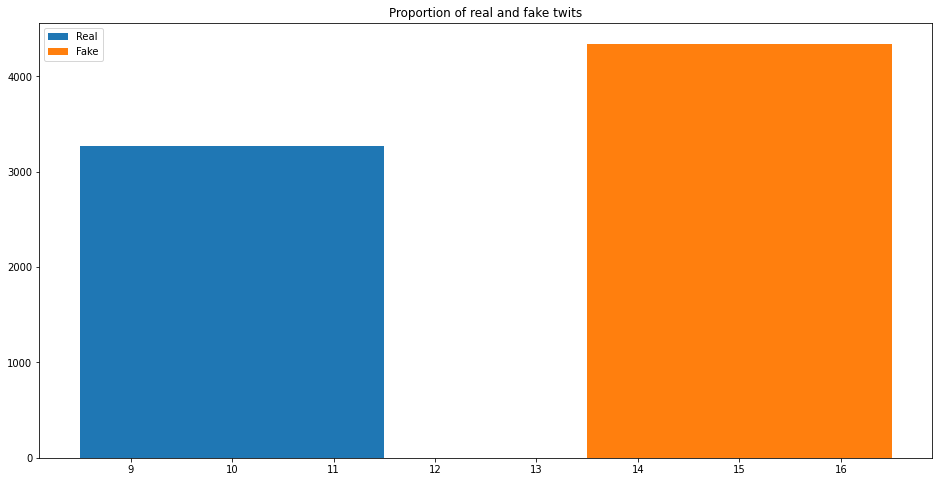

In [114]:
#Now the same but in bars

plt.bar(10, train_real, 3, label = "Real")
plt.bar(15, train_fake, 3, label = "Fake")
plt.legend()
plt.title("Proportion of real and fake twits")

In [0]:
def length(text):
    """Just to calculate length, it's tu use in an apply method. Probably there is a better way to do it
        but I can't think of one right now.
    """
    return len(text)

In [0]:
# I will remove these columns when I save the clean data but it's very useful to explore them.
train["length"] = train["text"].apply(length)
test["length"] = test["text"].apply(length)

Now I want to have a look to see how long are the fake and real tweets. That may be something Lacambra style.

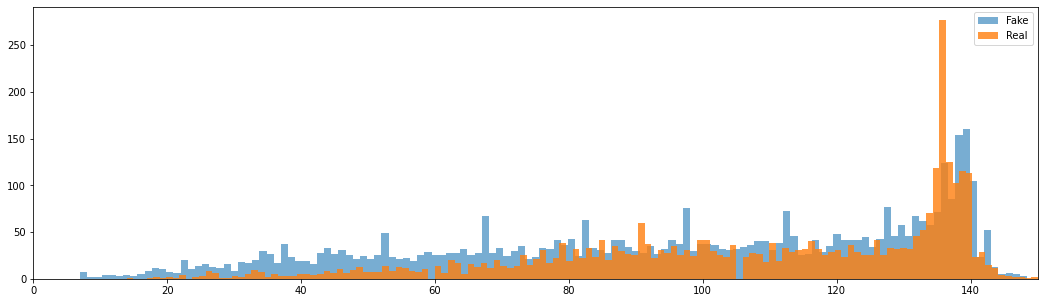

In [117]:
bins = 140 # Twitter has 280 chars, so I will group tweets of 1 and 2, 3 and 4, etc.

plt.rcParams["figure.figsize"] = (18, 5)
plt.hist(train[train["target"] == 0]["length"], alpha = 0.6, bins = bins, label = "Fake"); #Alpha is the transparency
plt.hist(train[train["target"] == 1]["length"], alpha = 0.8, bins = bins, label = "Real");
plt.xlim(0, 150)
plt.legend()
#plt.grid()

This is relatively uninforming but there are less real tweets that are very short. Let's see the length of the tweets in characters. It's not independent of the length but just for completeness.

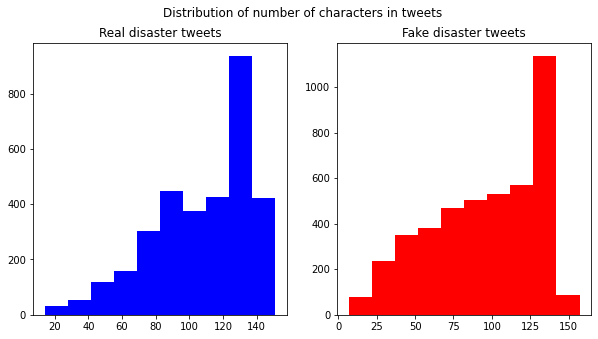

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

real_length = train[train["target"] == 1]["text"].str.len()
ax1.hist(real_length, color = "blue");
ax1.set_title("Real disaster tweets")
fake_length = train[train["target"] == 0]["text"].str.len()
ax2.hist(fake_length, color = "red");
ax2.set_title("Fake disaster tweets")
fig.suptitle("Distribution of number of characters in tweets");



The characters doesn't help. Most tweets are between 120 and 140 characters. But I can see the number of WORDS, not characters. Dimitri from Vladivostok may be lazy and generate always tweets with the same words. I can't see the number of words like that, I'll plot the average word length per tweet. That I can plot.

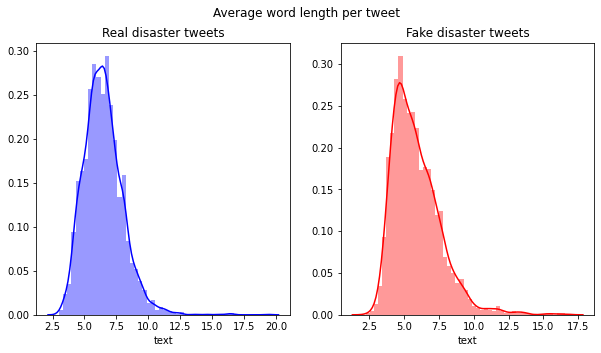

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

word = train[train["target"] == 1]["text"].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = "blue")
ax1.set_title("Real disaster tweets");

word = train[train["target"] == 0]["text"].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax2, color = "red")
ax2.set_title("Fake disaster tweets");

fig.suptitle("Average word length per tweet");

This doesn't tell me much, the distribution is almost identical. Dimitri has been industrious.

In [0]:
def create_corpus(target):
    
    corpus = []
    
    for x in train[train["target"] == target]["text"].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [0]:
def create_corpus_df(df, target):
    
    corpus = []
    
    for x in df[df["target"] == target]["text"].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

Let's focus on the fake tweets first (labeled 0)

In [122]:
#corpus = create_corpus(0)
corups = create_corpus_df(train, 0)
corups[0:10]


["What's", 'up', 'man?', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

This is working ok but I should check the stopwords. First with the fake tweets.

In [123]:
corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1 #Skip if it's a stop word

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]

#The key is the index to sort.
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

In [124]:
# and the stopwords are:

np.array(stop)

array({'needn', 'which', 'they', 'this', "should've", 'about', 'itself', 'with', "needn't", "you've", 'doesn', 'am', 'than', 'same', "doesn't", "that'll", 'haven', 'are', 'whom', 'ourselves', 'has', 'below', 'can', 'do', 'who', "you're", 'as', "aren't", "weren't", 'themselves', "she's", 'my', 'y', "hadn't", 'myself', 'just', 'isn', 'until', "mightn't", 'that', 'been', 'after', 'now', 'what', 'ours', 'should', 'couldn', 'she', 'be', 'to', 'being', 'over', 'very', 'an', 'him', 'wouldn', 'under', 'shouldn', 'yours', 'our', 'ma', 'only', 'for', 'down', 'but', 'hasn', 'both', "mustn't", 'any', "it's", 'each', 'weren', 'not', 'yourselves', 'at', 'd', 'during', 'out', 'i', "wouldn't", 'those', 'between', 'why', 'some', 'these', 'll', 'before', 'so', "don't", 'from', 'because', 'there', 'your', 'too', 'if', 'or', 'such', 'yourself', 'no', "haven't", 'through', 'having', 'their', 'was', "isn't", 'wasn', "wasn't", 'is', 'her', 'few', 'nor', 'while', 'had', 'were', "won't", 'have', 'o', 'does', '

Text(0.5, 1.0, 'Most common words in fake tweets')

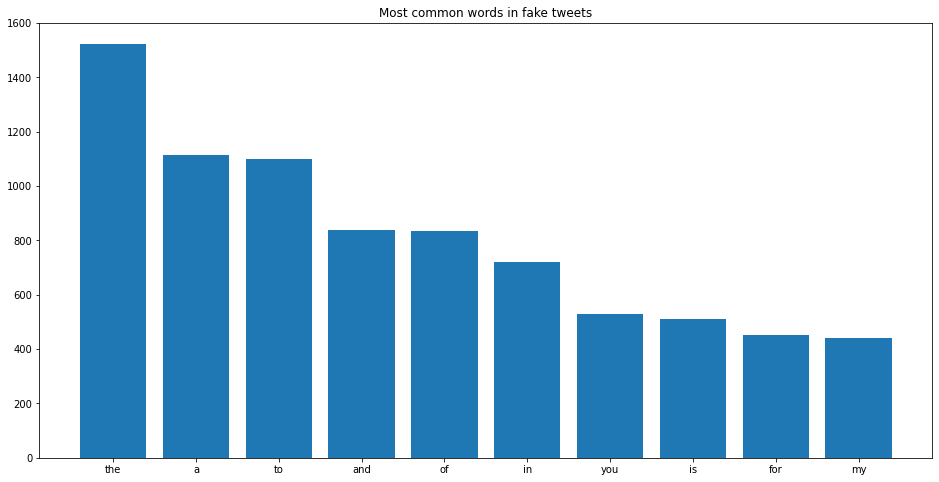

In [125]:
plt.rcParams["figure.figsize"] = (16, 8)

x, y = zip(*top) #This is unzipping the two values for each entry of top

plt.bar(x, y);
plt.title("Most common words in fake tweets")



In [126]:
#Now let's do the same with the other tweets.

corpus = create_corpus(1)

dic = defaultdict(int)

for word in (corpus):
    if word in stop:
        dic[word] += 1 #Skip if it's a stop word

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[:10]

#The key is the index to sort.
top

[('the', 1051),
 ('in', 1037),
 ('of', 888),
 ('a', 730),
 ('to', 706),
 ('and', 462),
 ('on', 386),
 ('for', 368),
 ('is', 302),
 ('at', 273)]

Text(0.5, 1.0, 'Most common words in fake tweets')

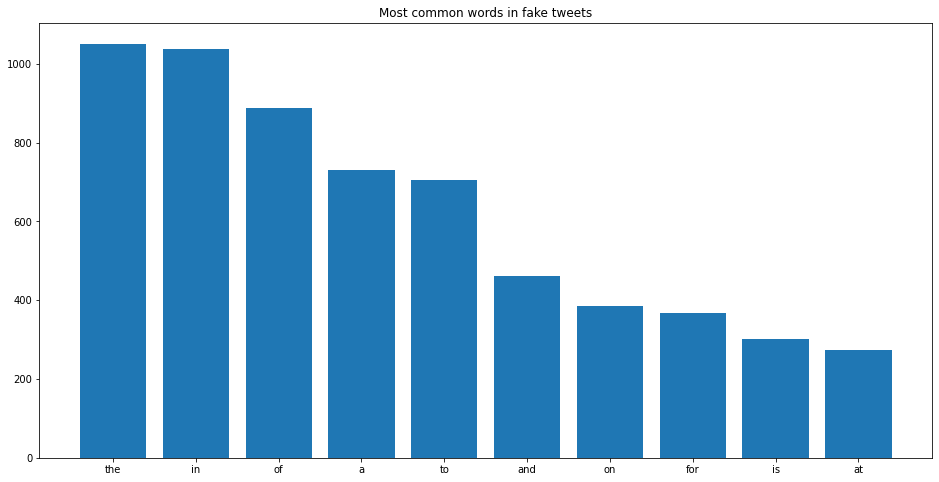

In [127]:
plt.rcParams["figure.figsize"] = (16, 8)

x, y = zip(*top) #This is unzipping the two values for each entry of top

plt.bar(x, y);
plt.title("Most common words in fake tweets")

# Punctuation analysis

The distribution is similar but not the same. Let's see a bit more focusing on punctuation. I'm going to do the same kind of analysis but with the punctuation. Since it's my primerito día with text, I just learnt there is a punctuation method. Mis dieses to these people.

In [128]:
corpus = create_corpus(0) #Start from the fake tweets.

dic = defaultdict(int)

punct = string.punctuation

for i in (corpus):
    if i in punct:
        dic[i] += 1

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)

top

[('-', 374),
 ('|', 91),
 (':', 30),
 ('?', 26),
 ('+', 24),
 ('@', 18),
 ('/', 17),
 ('=', 13),
 ('.', 12),
 ('!', 12),
 ('*', 11),
 ('~', 7),
 ("'", 6),
 ('#', 5),
 ('(', 5),
 (')', 2),
 ('/:', 1),
 ('_', 1),
 ('$', 1),
 ('%', 1)]

Text(0.5, 1.0, 'Punctuation in fake tweets')

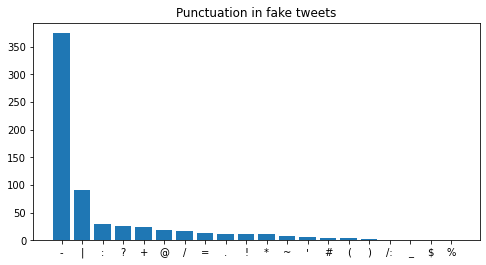

In [129]:
x, y = zip(*top)

plt.figure(figsize = (8, 4))
plt.bar(x, y);
plt.title("Punctuation in fake tweets")


Now the same with real tweets.

In [130]:
corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in punct:
        dic[word] += 1

top = sorted(dic.items(), key = lambda x: x[1], reverse = True)
top

[('-', 389),
 ('|', 51),
 (':', 31),
 ('/', 18),
 ('~', 14),
 ('?', 11),
 ('@', 9),
 ('.', 7),
 ('+', 7),
 ('!', 6),
 ("'", 5),
 ('=', 4),
 (';', 3),
 ('*', 3),
 ('#', 2),
 (']', 2),
 ('=>', 1),
 (')', 1)]

And we see the numbers are different. That is a good sign that I didn't take the same corpus.

Text(0.5, 1.0, 'Punctuation of real tweets')

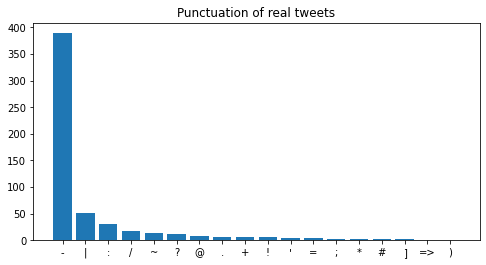

In [131]:
x_1, y_1 = zip(*top)

plt.figure(figsize = (8, 4))

#For side by side bar use seaborn with melt.
plt.bar(x_1, y_1);
plt.title("Punctuation of real tweets")



Let's see the most common words. Not the, a, etc.

In [132]:
corpus = create_corpus(0)

counter = Counter(corpus)
common = counter.most_common()
common[:20] #interesting that the and The are counted as two different words.

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('I', 938),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442),
 ('on', 387),
 ('-', 374),
 ('with', 349),
 ('that', 326),
 ('The', 295),
 ('it', 290),
 ('be', 268),
 ('like', 233),
 ('this', 225)]

In [0]:
x = []
y = []

for word, count in common:
    if word not in stop: #Don't count stopwords
        x.append(word)
        y.append(count)


In [0]:
#Previous cell takes long, separate the plotting

#plt.figure(figsize = (8, 4))
#plt.bar(x, y)

#sns.barplot(x = x, y = y)

Previous cell gives an error. I understand that this error means one of the character is not found. Probably due to encoding.

Now let's find the most common bigrams to see if there is any weird thing. I could also do any n-gram.

In [0]:
def get_top_ngrams(corpus, n = None):
    """Simply put, you get the corpus and find the bigrams.
    Then sort and take top n"""

    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    #See example: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    
    bag_of_words = vec.transform(corpus) # This is a sparse matrix
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word,idx in vec.vocabulary_.items()] # This gives the word frequency
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)[:n]
    return words_freq

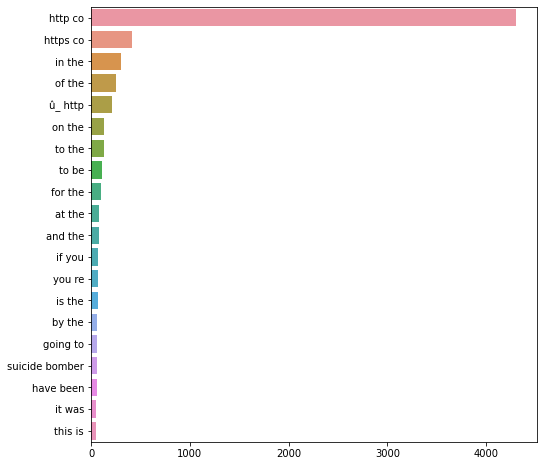

In [136]:
top_n_bigrams = get_top_ngrams(train["text"], n = 20)

x, y = map(list, zip(*top_n_bigrams))

plt.figure(figsize = (8,8))

sns.barplot(x = y, y = x)


And for the test set:

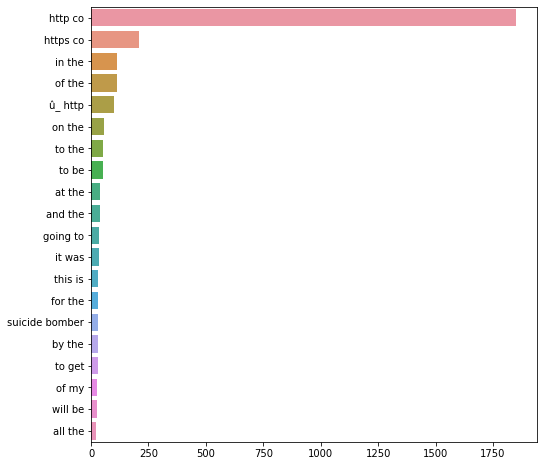

In [137]:
top_n_bigrams = get_top_ngrams(test["text"], n = 20)

x, y = map(list, zip(*top_n_bigrams))

plt.figure(figsize = (8,8))

sns.barplot(x = y, y = x)

The most common ones are links and they don't use https. In 2020...

# Data cleaning

In [0]:
df = pd.concat([train, test]) # Pass a list, not the two df separated by a comma

Now I have the dataset in a single df, let's remove punctuation, URLs, html tags, emojis and symbols.

In [0]:
def remove_punctuation(text):

    table = str.maketrans("", "", string.punctuation)
    # maketrans says: map x to x unless x it's in punctuation. The third argument is mapped to None.
    return text.translate(table)

In [139]:
example = "¡¡Cipote!!"

cleaning_test = remove_punctuation(example)
cleaning_test #Unsurprisingly, the punctuation is english, not espanish. Because I set it like that in the first cell.

'¡¡Cipote'

The best way to clean URLs is regular expressions. They can't be too bad.

In [0]:
def remove_urls(text):
    """This function removes urls with a RE"""

    url = re.compile(r"https?://\S+|www\.\S+")
    # https? means that the s may or may not be there. Because there is a ? right after the s.
    # h?ttps? means that the h and the s may or may not be there.
    # \S is a NOT white space. So it will match anything that is not a white space.
    # The | is because I'm matching either anything that is NOT a white space or www followed by .
    # The last \S is saying match anything (the . is wildcard) until you find a white space.
    # The + is 1 OR more. 
    # So reading: match the http(s):// and then: anything that is not space OR www and anything that is not white space
    # stop matching when you find white space (match NOT white space as many times as you find).

    return url.sub(r"", text)

In [144]:
example = "http://www.abc.com y ya no más"

cleaning_test = remove_urls(example)
cleaning_test

' y ya no más'

Same thing with html tags. I know they are between <>.

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    # Match < followed by anything, 0 or more times, which may or may not be there (?) and then >
    # this matches a real tag (<head>) and an empty one (<>)
    return html.sub(r'',text)


In [149]:
example = "aa <head and tails> b c "
example2 = "a<>b"

print(remove_html(example))
print(remove_html(example2))

aa  b c 
ab


Now remove the emojis. This is taken as is from slowkow. [Reference here](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)

In [150]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

And this is it. Now I am going to apply everything at the same time. Because it makes more sense and I only have to find one spot.

In [0]:
df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df["text"] = df["text"].apply(lambda x: remove_urls(x))
df["text"] = df["text"].apply(lambda x: remove_html(x))
df["text"] = df["text"].apply(lambda x: remove_emoji(x))

And it shouldn't complain. Last thing I need to do is save the clean dataset just in case.

In [0]:
df.to_csv("clean_dataset.csv")

And the cleaning is done. Next thing, start exploring and do more language related things. Bag of words, PCA or any of these bad ideas that I have.